## Finetuning distilBERT with Huggingface Trainer

Import the necessary libraries

In [ ]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

In [2]:
import os
import pandas as pd
import numpy as np
import evaluate
import torch
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from transformers import DistilBertForSequenceClassification
from transformers import AutoTokenizer

First we define the evaluation metrics

In [3]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy(labels, predictions),
        'precision': precision(labels, predictions),
        'recall': recall(labels, predictions),
        'f1': f1(labels, predictions),
    }

Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/'
data_path = os.path.join(base_path, 'NLP/hate_speech_detection_pipeline/data/train/balanced_train.csv')

if os.path.exists(data_path):
    data = pd.read_csv(data_path)
else:
    print("File not found. Please ensure the file path is correct and run the previous cell to create the file.")

Mounted at /content/drive


Next, we load the data and tokenize it using the Hugging Face tokenizer

In [5]:
# Aufteilen der Daten in Trainings- und Validierungsdatensätze
data = data.dropna(subset=['comment_text'])
train_size = int(0.9 * len(data))
data = data.sample(frac=1).reset_index(drop=True)
train_df = data[:train_size]
val_df = data[train_size:]

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples['comment_text'], truncation=True, padding='max_length', max_length=512)
    tokenized_inputs['labels'] = examples['hate']
    return tokenized_inputs

# Konvertierung von Pandas DataFrames in Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Anwenden der Tokenisierung
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['comment_text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['comment_text'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/29205 [00:00<?, ? examples/s]

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

Define the model

In [6]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now check if CPU or GPU available

In [7]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cuda for training


Now we define the training arguments and initialize the Trainer

In [ ]:
# Initialize TrainingArguments and Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    learning_rate = 5e-5, # The initial learning rate for AdamW optimizer.
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps = 100,
    evaluation_strategy="steps",  # instead of epochs
    eval_steps=100,
    save_strategy="steps",  # or "epoch"
    save_steps=100,  # saving parameters after 100 steps
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
)

# Trainer initialisieren
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Finally, we train the model

In [ ]:
# Training starten
trainer.train()

Save the model

In [10]:
from google.colab import drive

drive.mount('/content/drive')
base_path = '/content/drive/My Drive/'
data_path = os.path.join(base_path, 'NLP/hate_speech_detection_pipeline/model')

if not os.path.exists(data_path):
    os.makedirs(data_path)

model_file_path = os.path.join(data_path, 'new_model2.pth')
torch.save(model.state_dict(), model_file_path)

# Überprüfen, ob die Datei tatsächlich existiert
if os.path.isfile(model_file_path):
    print(f'Modell wurde erfolgreich unter {model_file_path} gespeichert.')
else:
    print('Fehler beim Speichern des Modells.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modell wurde erfolgreich unter /content/drive/My Drive/NLP/hate_speech_detection_pipeline/model/new_model2.pth gespeichert.


Visualize the training and validation loss per batch

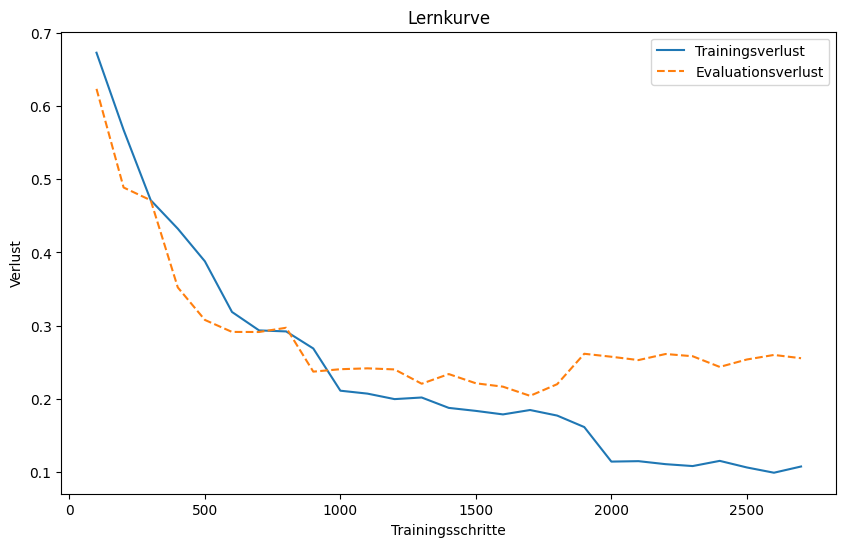

In [14]:
import json
import matplotlib.pyplot as plt

log_file_path = '/content/results/checkpoint-2700/trainer_state.json'  # Pfad zur Log-Datei

# Log-Daten laden
with open(log_file_path, 'r') as log_file:
    logs = json.load(log_file)

# Trainingsverlust extrahieren
train_steps = []
train_loss = []
for log in logs['log_history']:
    if 'loss' in log and 'step' in log:
        train_loss.append(log['loss'])
        train_steps.append(log['step'])

# Evaluationsverlust extrahieren, falls vorhanden
eval_steps = []
eval_loss = []
for log in logs['log_history']:
    if 'eval_loss' in log and 'step' in log:
        eval_loss.append(log['eval_loss'])
        eval_steps.append(log['step'])

# Lernkurve plotten
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Traininm')
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Evaluation loss', linestyle='--')
plt.xlabel('Traing steps (Batches)')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curve')
plt.show()

We see the model is overfitting after 1700 steps, so we take the model checkpoint at 1700 steps.

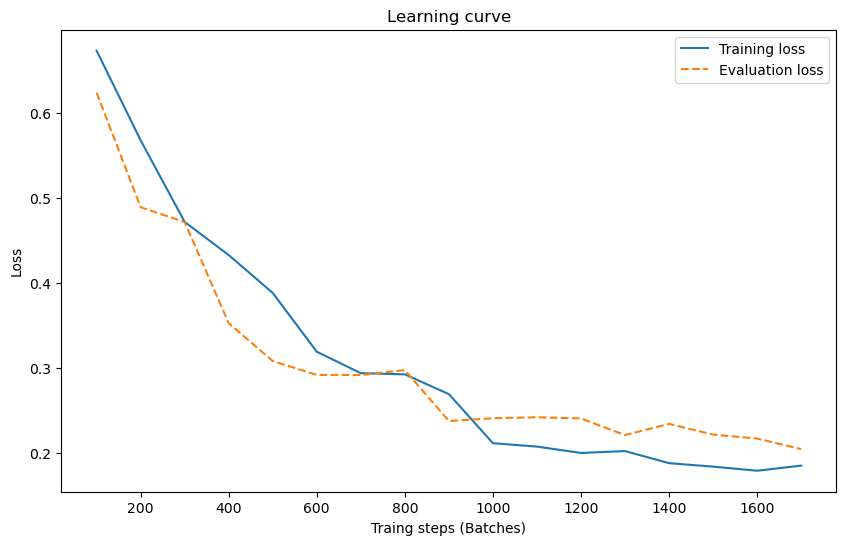

In [6]:
import json
import matplotlib.pyplot as plt

log_file_path = 'results/checkpoint-2700/trainer_state.json'  # Pfad zur Log-Datei

# Log-Daten laden
with open(log_file_path, 'r') as log_file:
    logs = json.load(log_file)

# Trainingsverlust extrahieren
train_steps = []
train_loss = []
for log in logs['log_history']:
    if 'loss' in log and 'step' in log and log['step'] <= 1700:
        train_loss.append(log['loss'])
        train_steps.append(log['step'])

# Evaluationsverlust extrahieren, falls vorhanden
eval_steps = []
eval_loss = []
for log in logs['log_history']:
    if 'eval_loss' in log and 'step' in log and log['step'] <= 1700:
        eval_loss.append(log['eval_loss'])
        eval_steps.append(log['step'])

# Lernkurve plotten
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training loss')
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Evaluation loss', linestyle='--')
plt.xlabel('Traing steps (Batches)')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curve')
plt.show()